In [1]:
import pickle
import pandas as pd
# Define the path to the .pkl file
input_path = "/data/sr933/scRCC/combined_data/RCC_data_dict.pkl"

# Load the dictionary from the .pkl file
with open(input_path, "rb") as f:
    data_dict = pickle.load(f)

# Access the contents of the dictionary
X_combined = data_dict["X"].T
y_labels = data_dict["y"]
gene_list = data_dict["Genes"]

df = pd.read_csv('/home/sr933/rcc/4_network_analysis/data/key_proteins_muanually_filtered.txt')
# Convert the 'Genes' column to a list
target_genes_list = df['Gene'].tolist()

# Get indices of elements in sublist from main_list
indices = [i for i, element in enumerate(gene_list) if element in target_genes_list]

# Select columns based on indices
filtered_X_train = X_combined[:, indices]
#y_labels[y_labels >= 1] = 1

In [2]:

# Path to the pickle file
pickle_file_path = "/data/sr933/scRCC validation/processed data/scRCC_validation_data.pkl"  # Path where you saved the file

# Load the pickle file
with open(pickle_file_path, "rb") as pkl_file:
    loaded_validation_data = pickle.load(pkl_file)

X_test=loaded_validation_data["X_data"]

# Filter X_data to only include rows present in target_indices
filtered_X_test = X_test.loc[target_genes_list].to_numpy().T
y_labels_test=X_test.columns
y_test= [0 if 'Tumor' in col else 1 for col in X_test.columns]


# UMAP of new dataset

In [3]:
import umap
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Initialize and fit UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Step 2: Transform the data
X_umap = reducer.fit_transform(filtered_X_test)

/home/sr933/miniconda3/envs/rcc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sr933/miniconda3/envs/rcc/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


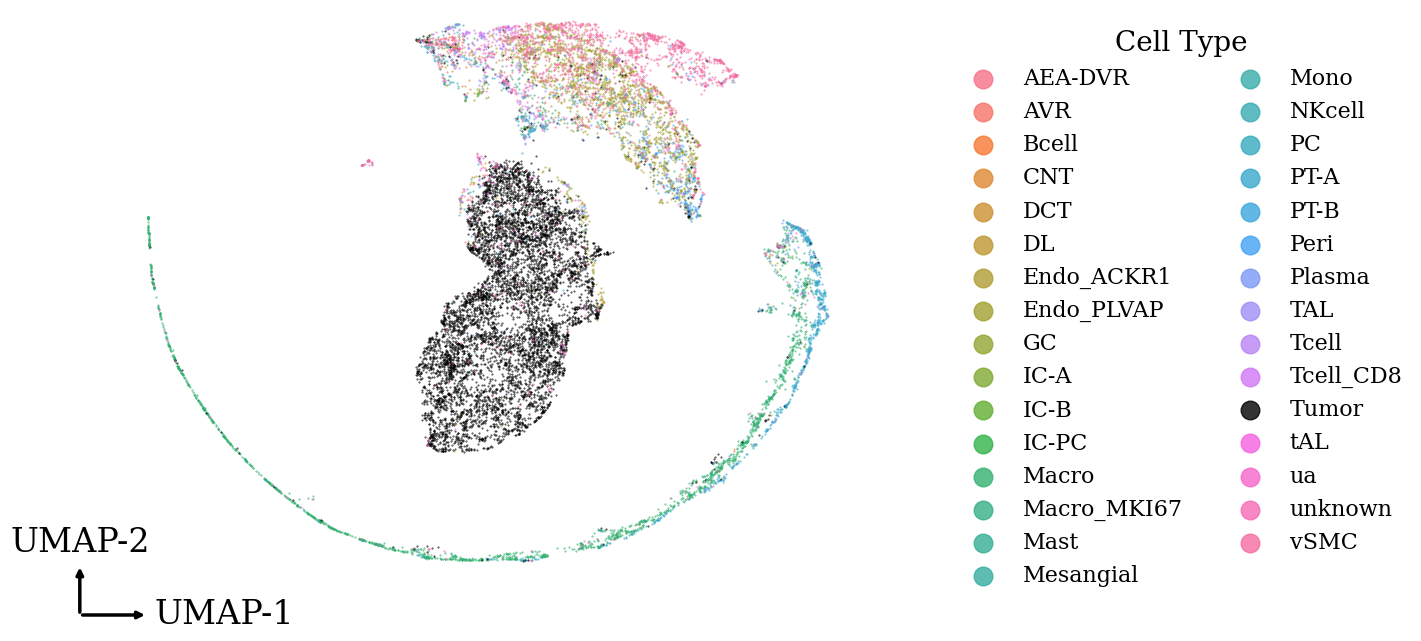

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Update plot parameters for Nature-style aesthetic
params = {
    "ytick.color": "black",
    "xtick.color": "black",
    "axes.labelcolor": "black",
    "axes.edgecolor": "black",
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
}
plt.rcParams.update(params)

# Define unique targets and sort them for consistency
targets = sorted(list(set(y_labels_test)))
num_targets = len(targets)

# Color palette
colors = sns.color_palette("husl", num_targets)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each cell type
for i, target in enumerate(targets):
    cell_colour = colors[i] if target.lower() != "tumor" else "k"  # Highlight Tumor
    mask = np.array(y_labels_test) == target
    ax.scatter(
        X_umap[mask, 0],
        X_umap[mask, 1],
        c=[cell_colour],
        label=target,
        s=0.2,
        alpha=0.8
    )

# Create legend
legend = ax.legend(
    title="Cell Type",
    fontsize=16,
    markerscale=30,
    loc="upper right",
    frameon=False,
    title_fontsize=20,
    bbox_to_anchor=(1.75, 1.0),
    ncol=2
)

# Remove axes
ax.axis("off")

# Arrow setup (bottom-left corner)
min_x, min_y = X_umap[:, 0].min(), X_umap[:, 1].min()
range_x = X_umap[:, 0].max() - min_x
range_y = X_umap[:, 1].max() - min_y

arrow_len_x = 0.1 * range_x
arrow_len_y = 0.1 * range_x  # Same scale for visual balance

# Define extra offset (padding from actual data to push arrows outside)
x_pad = 0.1 * range_x
y_pad = 0.1 * range_y

# New base corner for arrows (slightly below and to the left of the lowest data point)
arrow_base_x = min_x - x_pad
arrow_base_y = min_y - y_pad

# Draw axis arrows from padded bottom-left
ax.annotate("", xy=(arrow_base_x + arrow_len_x, arrow_base_y), xytext=(arrow_base_x, arrow_base_y),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2.5))
ax.annotate("", xy=(arrow_base_x, arrow_base_y + arrow_len_y), xytext=(arrow_base_x, arrow_base_y),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2.5))

# Axis labels near arrow tips
ax.text(arrow_base_x + arrow_len_x + 0.01 * range_x, arrow_base_y, "UMAP-1", fontsize=24, ha="left", va="center")
ax.text(arrow_base_x, arrow_base_y + arrow_len_y + 0.01 * range_y, "UMAP-2", fontsize=24, ha="center", va="bottom")

# Manually extend plot limits to ensure arrows and labels are visible
ax.set_xlim(arrow_base_x - 0.02 * range_x, X_umap[:, 0].max() + 0.02 * range_x)
ax.set_ylim(arrow_base_y - 0.02 * range_y, X_umap[:, 1].max() + 0.02 * range_y)

# Save figure
save_path = "/home/sr933/output/umap_american_drug_targets.png"  # Adjust as needed
plt.savefig(save_path, bbox_inches="tight", dpi=900)
plt.show()


# Classifier

In [16]:
##Do SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
def data_smote(x,y):
    oversample = SMOTE()
    x_new, y_new = oversample.fit_resample(x, y)

    counter_old = Counter(y)
    print(counter_old)
    counter = Counter(y_new)
    print(counter)

    #Make features binary
    x_new=np.rint(x_new)
    return x_new, y_new
y_labels[y_labels >= 1] = 1
X_smote, y_smote= data_smote(filtered_X_train, y_labels)

Counter({np.int64(1): 258428, np.int64(0): 14435})
Counter({np.int64(0): 258428, np.int64(1): 258428})


In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb

class_weights = {0: 1, 1: 1}
# Initialize the LGBMClassifier with binary classification settings
clf = lgb.LGBMClassifier(objective='binary', num_leaves=31, learning_rate=0.01, n_estimators=10000, class_weight=class_weights)

# Step 3: Train the model
clf.fit(X_smote, y_smote)

# Step 4: Make predictions

y_pred_prob = clf.predict_proba(filtered_X_test)[:, 1]
custom_threshold = 0.3
y_pred = (y_pred_prob > custom_threshold).astype(int)
# Step 5: Evaluate the model
clf.booster_.save_model('/home/sr933/rcc/data/lgbm_model_reduced.txt')
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 258428, number of negative: 258428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1271
[LightGBM] [Info] Number of data points in the train set: 516856, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


KeyboardInterrupt: 

[[6773  130]
 [3494 4702]]


(array([0.5, 1.5]), [Text(0, 0.5, 'TUM'), Text(0, 1.5, 'BEN')])

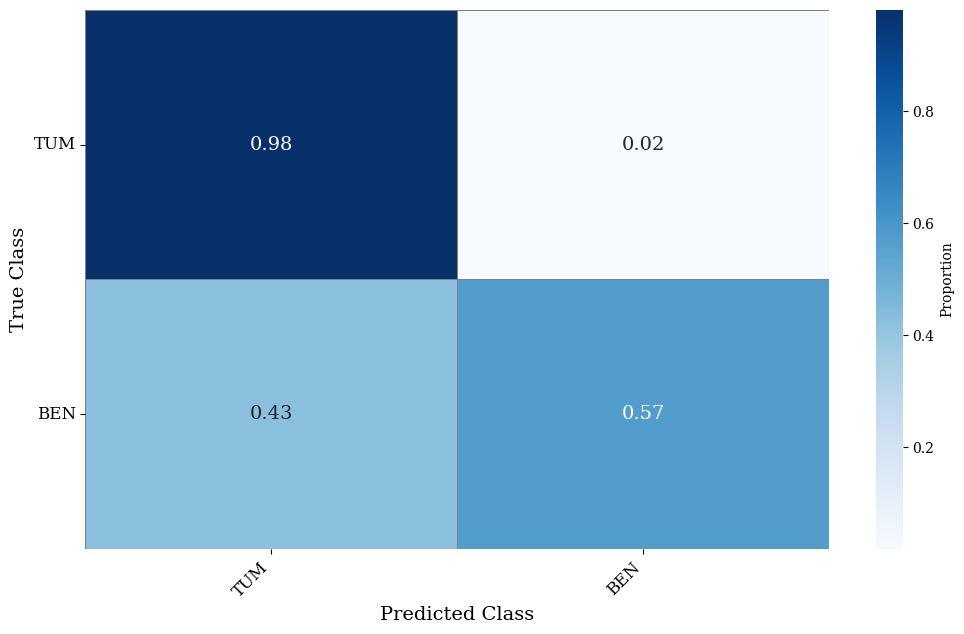

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)
classes=["TUM", "BEN"]
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index=classes, columns=classes)

plt.figure(figsize = (12,7))
# Create the heatmap with additional customization
sn.heatmap(df_cm, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, linecolor='gray', 
            cbar_kws={'label': 'Proportion'}, annot_kws={"size": 14})

# Axis labels and title
plt.ylabel("True Class", fontsize=14)
plt.xlabel("Predicted Class", fontsize=14)

# Ensure that axis labels are clearly visible
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

In [19]:
# Step 5: Evaluate the model
prob_dict = {"True": y_test, "Predicted": y_pred_prob}
df = pd.DataFrame(prob_dict)
df.to_csv('/home/sr933/rcc/data/predicted_prob_american_drug.csv', index=False)